In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Modified for single channel
])

In [23]:
train_data = datasets.MNIST(root="./data_mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data_mnist", train=False, download=True, transform=transform)

In [24]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False)

In [25]:
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
# Object Creation
model = DenoiseAE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

DenoiseAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [29]:
# Add Noise
def add_noise(img):
    noise = torch.randn(img.size(), device=img.device) * 0.5
    noisy_img = img + noise
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img

In [30]:
# Train
for epoch in range(20):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        noisy_img = add_noise(img)
        noisy_img = noisy_img.to(device)
        #forward
        output = model(noisy_img)
        loss = criterion(output, img)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, 20, loss.item()))

epoch [1/20], loss:0.9248
epoch [2/20], loss:0.9225
epoch [3/20], loss:0.9244
epoch [4/20], loss:0.9261
epoch [5/20], loss:0.9271
epoch [6/20], loss:0.9239
epoch [7/20], loss:0.9244
epoch [8/20], loss:0.9249
epoch [9/20], loss:0.9251
epoch [10/20], loss:0.9233
epoch [11/20], loss:0.9226
epoch [12/20], loss:0.9270
epoch [13/20], loss:0.9251
epoch [14/20], loss:0.9256
epoch [15/20], loss:0.9231
epoch [16/20], loss:0.9267
epoch [17/20], loss:0.9242
epoch [18/20], loss:0.9264
epoch [19/20], loss:0.9264
epoch [20/20], loss:0.9266


In [31]:
# Test
for data in test_loader:
    img, _ = data
    img = img.to(device)
    noisy_img = add_noise(img)
    noisy_img = noisy_img.to(device)
    output = model(noisy_img)
    print('loss:{:.4f}'.format(loss.item()))
    break

loss:0.9266


torch.Size([128, 1, 28, 84])


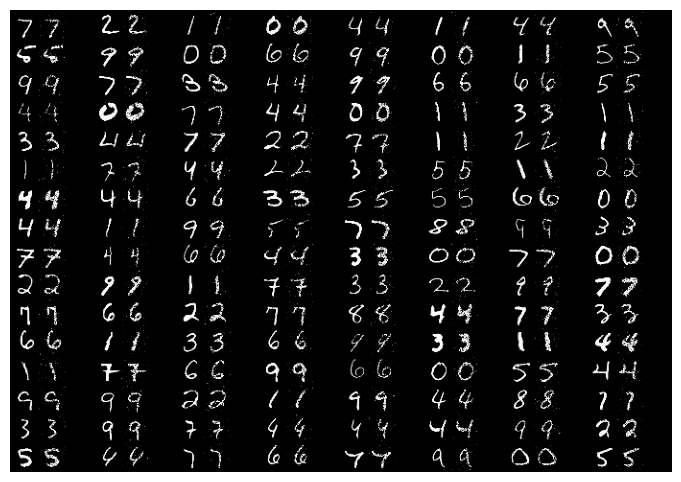

In [34]:
# Reconstruct
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(img, cmap='gray'):
    npimg = img.numpy()
    plt.figure(figsize=(12,6))
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap=cmap)
    plt.axis('off')
    plt.show()

show_img = torch.cat((img, noisy_img, output), 3)
show_img = show_img.cpu().data
print(show_img.size())
imshow(torchvision.utils.make_grid(show_img), cmap='gray')